In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from torch.autograd import Variable
from sklearn.decomposition import PCA
import pandas as pd
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
import matplotlib
import seaborn as sns 

In [105]:
#torch.manual_seed(1)

In [106]:
# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=False)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

print("train_dataset size:", len(train_dataset),"\ntest_dataset size:", len(test_dataset))

train_dataset size: 60000 
test_dataset size: 10000


In [107]:
# Data loader func
def train_loader(batch_size):
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size = batch_size, 
                                           shuffle=True)
    return train_loader


def test_loader(batch_size):
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)
    return test_loader

In [108]:
class DNN(nn.Module):
    def __init__(self,):
        super(DNN, self).__init__()
        # self.conv1 = nn.Conv2d(1, 6, 5)
        # self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(784, 500)
        # self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(500, 10)

    def forward(self, x):
        # x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        # x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        # flatten as one dimension
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))

        x = self.fc3(x)
        return x

In [109]:
#train function
def trainFunc(model,num_epochs,train_batch_size,status_interval):
    model.train()
    print('strated')
    train_load = train_loader(train_batch_size)
    n_total_steps = len(train_load)
    train_losses = []
    train_epoch = []
    train_acc = []
    epoch = 0
    modelParamWgt={}
    trainAvgLossArr = []
    trainAvgAccArr = []
    firstParaWgt={}
    #completeModelParam = {}
    for epoch in range (num_epochs):
        epoch += 1
        n_correct = 0
        n_samples = 0
        lossSum =0
        totalacc=0

        for i, (images, labels) in enumerate(train_load):  
            #if (i+1)% 60 == 0 : print(i+1)
            images, labels = Variable(images),Variable(labels)
            
            optimizer.zero_grad()
            
            # Forward pass
            prediction = model(images)

            images.requires_grad = True

            loss = loss_func(prediction, labels)
            lossSum += loss.detach().numpy()

            # Backward and optimize
            
            loss.backward()

            optimizer.step()

            _, predicted = torch.max(prediction.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            acc = 100.0 * n_correct / n_samples
            totalacc += acc

            train_losses.append(loss.item())
            train_acc.append(acc)
            train_epoch.append(epoch)

            #Print Status
            if (i+1) % status_interval == 0:
                print (f'Train O/P: Epoch [{epoch}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}',end= '\r',flush = True)
        
        #Weight Collection
        for name, parameter in model.named_parameters():
            #print(name)
            if'weight' in name:
                modelParamWgt[epoch] = torch.nn.utils.parameters_to_vector(parameter).detach().numpy()
                print(modelParamWgt)     
               
        if epoch % 3 == 0:
            torch.nn.utils.vector_to_parameters(torch.nn.utils.parameters_to_vector(model.parameters()),model.parameters())

        for name, parameter in model.named_parameters():
            #print(name)
            if'weight' in name:
                modelParamWgt[epoch] = torch.nn.utils.parameters_to_vector(parameter).detach().numpy()
                #print(modelParamWgt) 
        for name, parameter in M.named_parameters():
            if'fc1' in name and 'weight' in name:
                firstParaWgt[epoch] = torch.nn.utils.parameters_to_vector(parameter).detach().numpy()
                #print(firstParaWgt)
                        
        epochLoss = lossSum/(i+1)
        epochAcc = totalacc/(i+1)
        #print("Train Avg loss:",trainAvgLoss)
        trainAvgLossArr.append(epochLoss)    
        trainAvgAccArr.append(epochAcc)
                       
    return train_epoch,train_losses,train_acc,trainAvgLossArr,trainAvgAccArr, modelParamWgt,firstParaWgt

In [110]:
def testFunction(model,loss_func,test_batch_size): 
    test_load = test_loader(test_batch_size)
    model.eval()
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        testLoss = 0
        count = 0
        for images, labels in test_load:
            images, labels = Variable(images),Variable(labels)
            
            prediction = model(images)
            testLoss += loss_func(prediction,labels).item()
            # max returns (value ,index)
            _, predicted = torch.max(prediction.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            count += 1
    netTest_loss = testLoss/count
    netTest_acc1 = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the test images: {netTest_acc1}% & Test Loss: {netTest_loss}',end= '\r',flush = True)
    return netTest_acc1, netTest_loss

In [111]:
def pcaOps(paramDF,itr):
    pcaOperation =  PCA(n_components=2)

    scale = StandardScaler()

    sData = scale.fit_transform(paramDF)

    pcaVal = pcaOperation.fit_transform(sData)

    itrData = np.full((pcaVal.shape[0],1),itr)


    pcaDf = pd.DataFrame(np.append(pcaVal,itrData,axis=1),columns=['x','y','Itr No.'])

    return pcaDf


In [127]:
#2nd Approach

max_epochs = 12
all_df = pd.DataFrame()
columns=["x","y","Times"]
trainAllacc={}
testAllacc={}
trainAllloss={}
testAllloss={}
train_batch_size = 100
test_batch_size = 100
status_interval = 50
loss_func = nn.CrossEntropyLoss()
ittr = 8
firstLayer = pd.DataFrame()




for count in range(ittr):
    print("Time: "+str(count))

    #torch.manual_seed(1)
    
    M = DNN()
    optimizer = torch.optim.Adam(M.parameters(),lr = 0.0004,weight_decay=1e-4)
    model_name1 = "Times: "+str(count)    
    train_epoch,train_losses,train_acc,trainAvgLoss,trainAvgAccArr, modelParamWgt,firstParamWgt = trainFunc(M,max_epochs,train_batch_size,status_interval)
    testAcc, testLoss = testFunction(M,loss_func,test_batch_size)

    temp_df = pd.DataFrame(modelParamWgt).transpose()
    all_df = all_df.append(temp_df)

    firstdf = pd.DataFrame(firstParamWgt).transpose()
    firstLayer = firstLayer.append(firstdf)
    

    testAllacc[count] = testAcc
    trainAllloss[count] = trainAvgLoss
    testAllloss[count] = testLoss
    trainAllacc[count] = trainAvgAccArr



Time: 0
strated
{1: array([-8.4060164e-16, -3.1328411e-16,  1.3718551e-16, ...,
       -3.6429803e-14,  4.7069747e-17,  1.1607254e-16], dtype=float32)}
{1: array([ 0.06529455, -0.03570282, -0.1362069 , ..., -0.05825929,
        0.03834577,  0.02911522], dtype=float32)}
{1: array([ 0.06529455, -0.03570282, -0.1362069 , ..., -0.05825929,
        0.03834577,  0.02911522], dtype=float32), 2: array([ 1.7093265e-29, -1.1226930e-29,  7.4556312e-31, ...,
       -1.4230244e-27, -1.6013152e-30,  1.4512121e-29], dtype=float32)}
{1: array([ 0.06529455, -0.03570282, -0.1362069 , ..., -0.05825929,
        0.03834577,  0.02911522], dtype=float32), 2: array([ 0.064262  , -0.02378424, -0.1862729 , ..., -0.0653091 ,
        0.04074679,  0.03442317], dtype=float32)}
{1: array([ 0.06529455, -0.03570282, -0.1362069 , ..., -0.05825929,
        0.03834577,  0.02911522], dtype=float32), 2: array([ 0.064262  , -0.02378424, -0.1862729 , ..., -0.0653091 ,
        0.04074679,  0.03442317], dtype=float32), 3: arra

In [128]:
trainAccArr = []
for key,values in enumerate(trainAllacc):
    trainAccArr.append(trainAllacc[key])
trainLossArr = []
for key,values in enumerate(trainAllloss):
    trainLossArr.append(trainAllloss[key])


In [129]:
    all_df

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
1,0.065295,-0.035703,-0.136207,-0.103087,-0.062495,0.012414,-0.083528,0.025446,-0.071186,-0.035115,...,-0.027475,-0.096421,0.064421,0.033366,-0.095822,-0.088545,-0.070712,-0.058259,0.038346,0.029115
2,0.064262,-0.023784,-0.186273,-0.161112,-0.072895,0.024532,-0.086243,0.024538,-0.090400,-0.024379,...,-0.024682,-0.153686,0.089332,0.036824,-0.111996,-0.122485,-0.106809,-0.065309,0.040747,0.034423
3,0.065100,-0.013734,-0.235640,-0.207833,-0.088603,0.065081,-0.085231,0.028698,-0.115075,-0.011840,...,-0.075728,-0.192765,0.100652,0.032955,-0.130860,-0.149688,-0.129097,-0.062384,0.042584,0.036247
4,0.065933,-0.009858,-0.283627,-0.239819,-0.104963,0.088378,-0.085706,0.031124,-0.137793,-0.003379,...,-0.105554,-0.224120,0.110938,0.033466,-0.157425,-0.171009,-0.146046,-0.059309,0.042794,0.034802
5,0.065036,-0.011549,-0.325935,-0.268537,-0.122695,0.094679,-0.088956,0.032094,-0.155949,0.005176,...,-0.114385,-0.249760,0.119702,0.031568,-0.177870,-0.189982,-0.158770,-0.053939,0.041959,0.036015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8,0.068117,-0.017092,-0.416142,-0.330797,-0.185672,0.114339,-0.097834,0.046147,-0.211886,0.015943,...,-0.108101,-0.312700,0.143319,0.028899,-0.245909,-0.246202,-0.188524,-0.036102,0.035923,0.042269
9,0.070337,-0.019345,-0.439105,-0.350832,-0.202498,0.117578,-0.103299,0.049242,-0.230011,0.017168,...,-0.107863,-0.330472,0.147196,0.022876,-0.267875,-0.262915,-0.200793,-0.029745,0.034186,0.044103
10,0.069679,-0.023273,-0.455371,-0.370072,-0.218523,0.117755,-0.106115,0.050613,-0.244425,0.020315,...,-0.098716,-0.349994,0.156318,0.026607,-0.292416,-0.284121,-0.209101,-0.025243,0.031655,0.047070
11,0.069514,-0.030032,-0.476186,-0.388874,-0.235211,0.121821,-0.106834,0.057735,-0.257361,0.021689,...,-0.099521,-0.369168,0.156439,0.026559,-0.311481,-0.304778,-0.225700,-0.021642,0.031196,0.048540


In [130]:
train_acc_df = pd.DataFrame(trainAccArr)
train_acc_data = np.array(train_acc_df).flatten()

train_loss_df = pd.DataFrame(trainLossArr)
train_loss_data = np.array(train_loss_df).flatten()

print(f'Shape of Loss:{np.shape(train_loss_data)} & Shape of Acc: {np.shape(train_acc_data)}')


Shape of Loss:(96,) & Shape of Acc: (96,)


In [131]:
t1 = all_df
print(pd.DataFrame(t1))

        0         1         2         3         4         5         6     \
1   0.065295 -0.035703 -0.136207 -0.103087 -0.062495  0.012414 -0.083528   
2   0.064262 -0.023784 -0.186273 -0.161112 -0.072895  0.024532 -0.086243   
3   0.065100 -0.013734 -0.235640 -0.207833 -0.088603  0.065081 -0.085231   
4   0.065933 -0.009858 -0.283627 -0.239819 -0.104963  0.088378 -0.085706   
5   0.065036 -0.011549 -0.325935 -0.268537 -0.122695  0.094679 -0.088956   
..       ...       ...       ...       ...       ...       ...       ...   
8   0.068117 -0.017092 -0.416142 -0.330797 -0.185672  0.114339 -0.097834   
9   0.070337 -0.019345 -0.439105 -0.350832 -0.202498  0.117578 -0.103299   
10  0.069679 -0.023273 -0.455371 -0.370072 -0.218523  0.117755 -0.106115   
11  0.069514 -0.030032 -0.476186 -0.388874 -0.235211  0.121821 -0.106834   
12  0.071895 -0.029007 -0.488477 -0.402699 -0.245425  0.127767 -0.111107   

        7         8         9     ...      4990      4991      4992      4993  \
1   0.

In [132]:
t1 = np.array(t1)
pca = PCA(n_components=2)
new_data = pca.fit_transform(t1)
# scaling=StandardScaler()
# scaled_data = scaling.fit_transform(new_data)

allEpochDf = pd.DataFrame(new_data,columns=['x','y'])

eps_each_time = [i for i in range(max_epochs)] * 8
times = np.repeat([i for i in range(8)],max_epochs)

allEpochDf['eps'] = eps_each_time
allEpochDf['time'] = times
allEpochDf["Acc"] = train_acc_data
allEpochDf["Loss"] = train_loss_data

allEpochDf


,x,y,eps,time,Acc,Loss
0,3.628497,0.669586,0,0,82.932006,0.410574
1,2.688007,0.098671,1,0,94.140449,0.185431
2,1.883086,-0.209275,2,0,96.033236,0.132638
3,1.182704,-0.337212,3,0,97.002958,0.102216
4,0.563491,-0.362579,4,0,97.683006,0.083211
...,...,...,...,...,...,...
91,-1.022386,-0.117550,7,7,98.585768,0.051229
92,-1.477574,0.003788,8,7,98.744407,0.045048
93,-1.908785,0.134932,9,7,99.109004,0.038947
94,-2.310359,0.267555,10,7,99.221673,0.034930


In [133]:
epoch3Df = allEpochDf.loc[(allEpochDf['eps']+1)%3 == 0]
epoch3Df = epoch3Df.reset_index(drop=True)
epoch3Df

,x,y,eps,time,Acc,Loss
0,1.883086,-0.209275,2,0,96.033236,0.132638
1,-0.005312,-0.315419,5,0,98.116560,0.069274
2,-1.477574,0.003788,8,0,98.744407,0.045048
3,-2.685449,0.394688,11,0,99.242878,0.031745
4,1.883086,-0.209275,2,1,96.033236,0.132638
5,-0.005312,-0.315419,5,1,98.116560,0.069274
6,-1.477574,0.003788,8,1,98.744407,0.045048
7,-2.685449,0.394688,11,1,99.242878,0.031745
8,1.883086,-0.209275,2,2,96.033236,0.132638
9,-0.005312,-0.315419,5,2,98.116560,0.069274


In [134]:
test = np.array(epoch3Df.Acc)
mv = []
for i in range(len(test)):
    mv.append(str(int(test[i])))
len(mv)

32

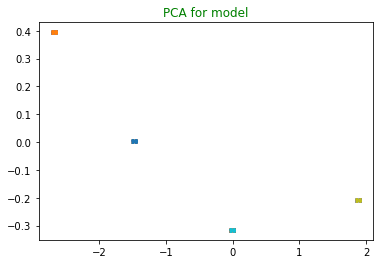

In [135]:
for i in range(len(mv)):
    m = mv[i]
    plt.scatter(epoch3Df['x'][i],epoch3Df['y'][i],marker=f'${m}$')
    plt.title("PCA for model",color="g")

plt.savefig('D:/Clemson/COURSE/SEM-2/CPSC-8430 Deep Learning - 001/Homework/CPSC-8430-Deep-Learning-001/HW1/plots/PCA_1Copy.jpg',
            format='jpeg',
            dpi=700,
            bbox_inches='tight')

plt.show()

In [136]:
epoch1stEpoch= allEpochDf.loc[(allEpochDf['eps']+1) == 1]
epoch1stEpoch = epoch1stEpoch.reset_index(drop=True)
epoch1stEpoch

,x,y,eps,time,Acc,Loss
0,3.628497,0.669586,0,0,82.932006,0.410574
1,3.628496,0.669586,0,1,82.932006,0.410574
2,3.628496,0.669586,0,2,82.932006,0.410574
3,3.628496,0.669586,0,3,82.932006,0.410574
4,3.628496,0.669586,0,4,82.932006,0.410574
5,3.628496,0.669586,0,5,82.932006,0.410574
6,3.628496,0.669586,0,6,82.932006,0.410574
7,3.628496,0.669586,0,7,82.932006,0.410574


In [137]:
test = np.array(epoch1stEpoch.Acc)
fl = []
for i in range(len(test)):
    fl.append(str(int(test[i])))
len(fl)

8

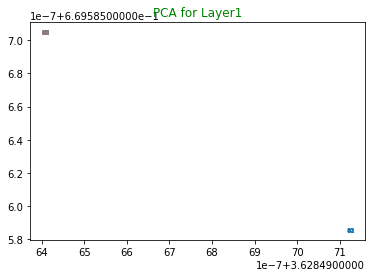

In [138]:
for i in range(len(fl)):
    m = fl[i]
    plt.scatter(epoch1stEpoch['x'][i],epoch1stEpoch['y'][i],marker=f'${m}$')
    plt.title("PCA for Layer1",color="g")

plt.savefig('D:/Clemson/COURSE/SEM-2/CPSC-8430 Deep Learning - 001/Homework/CPSC-8430-Deep-Learning-001/HW1/plots/PCA_Layer1.jpg',
            format='jpeg',
            dpi=700,
            bbox_inches='tight')

plt.show()

In [139]:
tF = firstdf

tF = np.array(tF)
pca = PCA(n_components=2)
new_data2 = pca.fit_transform(tF)

firstLayDf = pd.DataFrame(new_data2,columns=['x','y'])

eps_each_time = [i for i in range(max_epochs)] * 8
times = np.repeat([i for i in range(8)],max_epochs)

#firstLayDf['eps'] = eps_each_time
#firstLayDf['time'] = times
#firstLayDf["Acc"] = train_acc_data
#firstLayDf["Loss"] = train_loss_data

# firstLayDf

# test = np.array(firstLayDf.Acc)
# fl = []
# for i in range(len(test)):
#     fl.append(str(int(test[i])))
# len(fl)


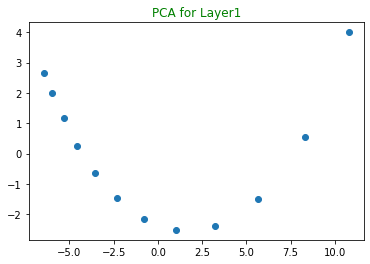

In [140]:
plt.scatter(firstLayDf['x'],firstLayDf['y'])
plt.title("PCA for Layer1",color="g")

plt.savefig('D:/Clemson/COURSE/SEM-2/CPSC-8430 Deep Learning - 001/Homework/CPSC-8430-Deep-Learning-001/HW1/plots/PCA_Layer1_2.jpg',
            format='jpeg',
            dpi=700,
            bbox_inches='tight')

plt.show()

In [141]:
len(tF)

12